## Import libraries

In [34]:
import numpy as np
from numpy import sqrt, argmax
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

import pandas as pd
import re
from nltk.corpus import stopwords

import syft as sy

from handcrafted_GRU import GRU
from torch.utils.data import DataLoader, TensorDataset
print(torch.cuda.is_available())

True


In [47]:
STOPWORDS = set(stopwords.words('indonesian'))
# print(f"STOPWORDS:\n {STOPWORDS}")

def clean_text(text):
    print(f"\n\nOriginal Text: {text}")
    text = text.lower()
#     print(f"\nCase Lowered Text: {text}")
    text = re.sub(r'[^a-z\s]', '', text)
#     print(f"\nRegexed Text: {text}")
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
#     print(f"\nStopwords Removed Text: {text}")
    return text

def tokenize(text, word_to_idx):
    tokens = []
    for word in text.split():
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(0)
    return tokens

def pad_and_truncate(messages, max_length=30):
    features = np.zeros((len(messages), max_length), dtype=int)
#     pprint(f"Messages: {messages}\nFeatures: {features}")
    for i, sms in enumerate(messages):
#         print(f"\ni: {i}\nSMS:{sms}")
        if len(sms):
            features[i, -len(sms):] = sms[:max_length]
    return features


if __name__ == '__main__':
    data = pd.read_csv('dataset_sms_spam_v1.csv', sep=',', names=['Teks', 'Label'])
    data = data.sample(frac = 1)
    #Lowercase, remove unnecessary char with regex, remove stop words
    data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
    words = set((' '.join(data.Teks)).split())
#     print(words)
    word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
    tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
    inputs = pad_and_truncate(tokens)
#     pprint(inputs)
    labels = np.array((data.Label == '1').astype(int))

    np.save('labels.npy', labels)
    np.save('inputs.npy', inputs)



Original Text: PESAN RESMI PT.3Care Indonesia Berkat isi Ulang No. Anda Resmi meraih hadiah ke-1 Dengan kode PIN Anda {8JF2177} U/Info Hadiahlik: www.berkat-isiulang3care.blogspot.com


Original Text: Buruan Download & Registrasi myCare di http://bit.ly/mycarepLy dan dapatkan Promo 10GB (4G) di Paket Freedoom M & L dengan harga khusus HANYA HARI INI.


Original Text: Oh udah yah haha aku bingung jd gimana udh ketinggalan banyak chat


Original Text: Selamat,Anda M-dptkan Hadiah 1 Unit Mobil HONDA JAZZ & UANG TUNAI 35JT Rs Dr PT.TriCare PIN Pemenang Anda;477bfg7s. U/info klik: www.tricareindonesia.com


Original Text: Selamat! Anda sudah mengaktifkan INSTINK utk dpt info menarik dari Telkomsel. Info berhenti program:*600*600#. CS:133/188


Original Text: Plg Yth: Simcard anda mendptkan bonus poin plus-plus 555 dr:PT.INDOSAT pin anda:277fg49 u/info klik di www.indosat-555.blogspot.com atau Hub:021-3338-0074.


Original Text: MODAL USAHA : Solusi keuangan anda hanya copy ktp, kartu kred

## Loading data

In [3]:
inputs = np.load('inputs.npy')
labels = np.load('labels.npy')

## Training model with Federated learning

### Training and model hyperparameters

In [4]:
# Training params
TRAIN_VOCAB_SIZE = int(inputs.max()) + 1
EPOCHS = 20
CLIP = 5 # gradient clipping - to avoid gradient explosion (frequent in RNNs)
lr = 0.001
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Initiating virtual workers with Pysyft

In [5]:
labels = torch.tensor(labels)
inputs = torch.tensor(inputs)

# splitting training and test data
# 20% of the data will be for Tests.
pct_test = 0.2

#20% of total data
pct_test_count = -int(len(labels)*pct_test)

# Get 80% of Train LABELS from left.
train_labels = labels[:pct_test_count]
print(f"Train Labels: [:{pct_test_count}]")

# Get 80% of Train INPUTS from left.
train_inputs = inputs[:pct_test_count]
print(f"Train Inputs: [:{pct_test_count}]")

# Get the rest of the LABEL data for test on the right (20%) 
test_labels = labels[pct_test_count:]
print(f"Test Labels: [{pct_test_count}:]")

# Get the rest of the INPUT data for test on the right (20%)
test_inputs = inputs[pct_test_count:]
print(f"Test Inputs: [{pct_test_count}:]")

print(f"Length Labels: {len(labels)}")
print(f"20% of Length Labels: {len(labels)*pct_test}")

Train Labels: [:-228]
Train Inputs: [:-228]
Test Labels: [-228:]
Test Inputs: [-228:]
Length Labels: 1144
20% of Length Labels: 228.8


In [6]:
# Hook that extends the Pytorch library to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(torch)

# Creating 2 virtual workers
bob = sy.VirtualWorker(hook, id="bob")
anne = sy.VirtualWorker(hook, id="anne")

# threshold indexes for dataset split (one half for Bob, other half for Anne)
train_idx = int(len(train_labels)/2)
test_idx = int(len(test_labels)/2)

# Sending toy datasets to virtual workers
bob_train_dataset = sy.BaseDataset(train_inputs[:train_idx], train_labels[:train_idx]).send(bob)
anne_train_dataset = sy.BaseDataset(train_inputs[train_idx:], train_labels[train_idx:]).send(anne)
bob_test_dataset = sy.BaseDataset(test_inputs[:test_idx], test_labels[:test_idx]).send(bob)
anne_test_dataset = sy.BaseDataset(test_inputs[test_idx:], test_labels[test_idx:]).send(anne)

# Creating federated datasets, an extension of Pytorch TensorDataset class
federated_train_dataset = sy.FederatedDataset([bob_train_dataset, anne_train_dataset])
federated_test_dataset = sy.FederatedDataset([bob_test_dataset, anne_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [7]:
# Initiating the model
model = GRU(vocab_size=TRAIN_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)

### Training

For now, PySyft does not support optimizers with momentum. Therefore, we are going to stick with the classical [Stochastic Gradient Descent](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer.

As our task consists of a binary classification, we are going to use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

In [8]:
# Defining loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

For each epoch we are going to compute the training and validations losses, as well as the [Area Under the ROC Curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) score due to the fact that the target dataset is unbalaced (only 13% of labels are positive).

In [9]:
train_losses = []
test_losses = []
for e in range(EPOCHS):
    
    ######### Training ##########
    
    losses = []
    # Batch loop
    for inputs, labels in federated_train_loader:
        # Location of current batch
        worker = inputs.location
        # Initialize hidden state and send it to worker
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
        # Send model to current worker
        model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = model(inputs.to(torch.long), h)
        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # Clipping the gradient to avoid explosion
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        model.get()
        losses.append(loss.get())
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in federated_test_loader:
            # get current location
            worker = inputs.location
            # Initialize hidden state and send it to worker
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)    
            # Send model to worker
            model.send(worker)

            output, _ = model(inputs.to(torch.long), h)
            loss = criterion(output.squeeze(), labels.float())
            eval_losses.append(loss.get())
            preds = output.squeeze().get()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.get().numpy().astype(int))
            # Get the model back to the local worker
            model.get()

    #Check test preds
    score = roc_auc_score(test_labels_list, test_preds)

    train_loss = sum(losses)/len(losses)
    eval_loss = sum(eval_losses)/len(eval_losses)
    train_losses.append(train_loss.item())
    test_losses.append(eval_loss.item())
    
    print("Epoch {}/{}...  \
    AUC: {:.3%}...  \
    Training loss: {:.5f}...  \
    Validation loss: {:.5f}".format(e+1, EPOCHS, score, train_loss, eval_loss))
    
    model.train()

Epoch 1/20...      AUC: 55.459%...      Training loss: 0.73576...      Validation loss: 0.71766
Epoch 2/20...      AUC: 55.545%...      Training loss: 0.73666...      Validation loss: 0.71758
Epoch 3/20...      AUC: 55.583%...      Training loss: 0.73079...      Validation loss: 0.71511
Epoch 4/20...      AUC: 55.631%...      Training loss: 0.73474...      Validation loss: 0.71265
Epoch 5/20...      AUC: 55.755%...      Training loss: 0.72104...      Validation loss: 0.71038
Epoch 6/20...      AUC: 55.774%...      Training loss: 0.72639...      Validation loss: 0.70755
Epoch 7/20...      AUC: 55.840%...      Training loss: 0.72702...      Validation loss: 0.70532
Epoch 8/20...      AUC: 55.945%...      Training loss: 0.72014...      Validation loss: 0.70317
Epoch 9/20...      AUC: 56.040%...      Training loss: 0.71713...      Validation loss: 0.69868
Epoch 10/20...      AUC: 56.202%...      Training loss: 0.71712...      Validation loss: 0.69699
Epoch 11/20...      AUC: 56.307%...    

### Plot Losses

Train Losses: [0.7357639670372009, 0.7366594076156616, 0.7307906150817871, 0.7347350716590881, 0.7210411429405212, 0.7263932824134827, 0.7270220518112183, 0.7201370000839233, 0.7171270847320557, 0.7171213626861572, 0.7121627330780029, 0.7162520885467529, 0.7159433364868164, 0.7091524600982666, 0.7034502625465393, 0.7031574845314026, 0.692426323890686, 0.7020524144172668, 0.7018092274665833, 0.6937656998634338]


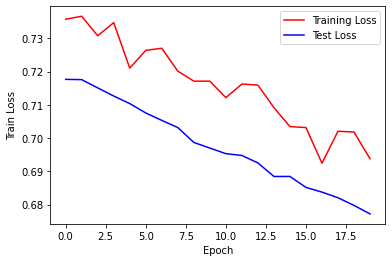

In [10]:
print(f"Train Losses: {train_losses}")
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Saving model for inference

In [11]:
# Save
PATH = "state_dict_model.pt"
torch.save(model.state_dict(), PATH)

### Ask for input and pre-process text

In [40]:
# text = "Selamat Anda Mendapatkan 50 JUTA!"
# ctext = clean_text(text)
# print(ctext)
# words = ctext.split()
# print(words)
# words = set((' '.join(words)).split())
# token_holder = []
# tokens = tokenize(text, word_to_idx)
# print(f"Tokens:{tokens}")
# # print(word_to_idx)
# token_holder.append(tokens)
# inference_input = pad_and_truncate(token_holder)
# print(f"\nPadded Inputs: {inference_input}")

In [48]:
data = pd.read_csv('dataset_sms_spam_v1.csv', sep=',', names=['Teks', 'Label'])
data = data.sample(frac = 1)
# Lowercase, remove unnecessary char with regex, remove stop words
data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
words = set((' '.join(data.Teks)).split())
#     print(words)
word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
inputs = pad_and_truncate(tokens)
#     pprint(inputs)
labels = np.array((data.Label == '1').astype(int))

np.save('test_labels.npy', labels)
np.save('test_inputs.npy', inputs)

test_inputs = torch.tensor(np.load('test_inputs.npy'))
test_labels = torch.tensor(np.load('test_labels.npy'))




Original Text: PESAN RESMI PT.3care indonesia Mengucapkan slmt'No.simcard anda resmi meraih hadiah ke-3 dengan pin ; b8337h9 u/info hadiah klik www.pesta-hadiah3.blogspot.com


Original Text: Dimulai dari angka 0


Original Text: solusi khusus pemegang kartu kredit, nikmati kredit tanpa angunan dari bank asing 5 - 99 jt = 1,79 % 100 - 150 jt = 1,5% hub: lukman 081586769255 021 - 94828857


Original Text: SELAMAT!! Anda M-dapat hadiah Satu unit mobil alphard dr TELKOMSEL info hub;0016282336033777/kunjungi website kami di http://telkomselundian2013.jimdo.com


Original Text: Nikmati EXTRA 2GB 4G LTE + EXTRA voucher belanja hingga 100rb dg beli pkt FLASH 1GB/30hr mulai Rp 43rb di *363*49# Cek tarif di tsel.me/FL SKB


Original Text: Selamat ulang tahun semoga panjang umur dan sehat selalu


Original Text: Iya kar lg dikosan nih. Numpang ap?


Original Text: Masih ingat dengan Warkop DKI ? Dapatkan NSP nya GRATIS dengan akses ke *600# dan dapatkan promo gratis lainnya sesuai dengan hobim

In [50]:
# Testing params
VOCAB_SIZE = int(test_inputs.max()) + 1
TEST_VOCAB_SIZE = TRAIN_VOCAB_SIZE
lr = 0.001
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Load Model

In [51]:
PATH = "state_dict_model.pt"
model = GRU(vocab_size=TEST_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
model.load_state_dict(torch.load(PATH))
model.eval()

GRU(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(4174, 50)
  (gru_cell): GRUCell(
    (fc_ir): Linear(in_features=50, out_features=10, bias=True)
    (fc_hr): Linear(in_features=10, out_features=10, bias=True)
    (fc_iz): Linear(in_features=50, out_features=10, bias=True)
    (fc_hz): Linear(in_features=10, out_features=10, bias=True)
    (fc_in): Linear(in_features=50, out_features=10, bias=True)
    (fc_hn): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [52]:
from sklearn.metrics import f1_score
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for inputs, labels in test_loader:
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))

        output, _ = model(inputs.to(torch.long), h)
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        test_preds += list(preds.numpy())
        test_labels_list += list(labels.numpy().astype(int))


roc_acc_score = roc_auc_score(test_labels_list, test_preds)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# Index of largest G-means
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

# Print how many data is being tested
print(f"Amount of test data: {len(test_labels_list)}")


# # Plot ROC Curve
# plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# plt.plot(fpr, tpr, marker='.', label='Logistic')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# # show the plot
# plt.show()

    
print(f"ROC Accuracy Score: {roc_acc_score}")

# Normalize probability with threshold
test_preds_thresholded = np.where(test_preds > threshold, 1, 0)
for i in range(len(test_preds)):
    print("Test Preds Prob: {}    \
    Test Preds Label: {}  \
    True Label: {}  \
    ".format(test_preds[i], test_preds_thresholded[i], test_labels_list[i]))

acc_score = accuracy_score(test_labels_list, test_preds_thresholded)
print(f"\nAccuracy Score: {acc_score}")

f1_score = f1_score(test_labels_list, test_preds_thresholded)
print(f"F1 Score: {f1_score}")


Best Threshold=0.488951, G-Mean=0.527
Amount of test data: 1144
ROC Accuracy Score: 0.5307824290168441
Test Preds Prob: 0.4476601183414459        Test Preds Label: 0      True Label: 0      
Test Preds Prob: 0.4917354881763458        Test Preds Label: 1      True Label: 0      
Test Preds Prob: 0.5971219539642334        Test Preds Label: 1      True Label: 0      
Test Preds Prob: 0.4796336889266968        Test Preds Label: 0      True Label: 0      
Test Preds Prob: 0.5084230899810791        Test Preds Label: 1      True Label: 0      
Test Preds Prob: 0.5562991499900818        Test Preds Label: 1      True Label: 0      
Test Preds Prob: 0.4806418716907501        Test Preds Label: 0      True Label: 1      
Test Preds Prob: 0.3464047908782959        Test Preds Label: 0      True Label: 0      
Test Preds Prob: 0.34602513909339905        Test Preds Label: 0      True Label: 0      
Test Preds Prob: 0.3883151710033417        Test Preds Label: 0      True Label: 0      
Test Preds Prob: